In [36]:
import os
import numpy as np
import pandas as pd
import cv2
from ultralytics import YOLO
from tqdm import tqdm  # nice progress bars
import time
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [7]:
# Traning YOLO Detector on Dataset
detector = YOLO("runs/detect/detector_opt/weights/last.pt")
detector.train(
    data="dataset/data.yaml",
    epochs=15,         # enough 
    imgsz=320,         # smaller, much faster
    batch=2,           # safe for 8GB VRAM
    device=0,          # use GPU
    workers=1,         # smooth dataloading
    amp=True,          # reduces VRAM by ~30%
    val=False,         # saves 35% time
    name="detector_opt",
    resume=True
)

Ultralytics 8.3.228  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\detector_opt\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=detector_opt, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002034CBE06D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

In [13]:
# crops the bounding box for each detected pest and saves into new dataset folder
detector_opt = YOLO("runs/detect/detector_opt/weights/best.pt")
data_root = "dataset"
output_root = "cls_dataset" # new classsification dataset
splits = ["train", "valid", "test"]
# create output folders
for split in splits:
    for cls_name in detector_opt.names.values():
        os.makedirs(os.path.join(output_root, split, cls_name), exist_ok=True)
# func to crop boxes
def crop(img_path, results, save_dir):
    img = cv2.imread(img_path)
    for r in results:
        for box, cls_id in zip(r.boxes.xyxy, r.boxes.cls):
            x1, y1, x2, y2 = map(int, box)     # convert tensors into ints
            cls_name = detector_opt.names[int(cls_id)]
            crop = img[y1:y2, x1:x2]         
            if crop.size == 0:
                continue
            base = os.path.basename(img_path)
            save_path = os.path.join(save_dir, cls_name, base)
            cv2.imwrite(save_path, crop)

# process all dataset splits
for split in splits:
    img_dir = os.path.join(data_root, split, "images")
    save_dir = os.path.join(output_root, split)

    images = [os.path.join(img_dir, f) for f in os.listdir(img_dir)
              if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    print(f"\nProcessing {split} ({len(images)} images) ...")

    for img_path in tqdm(images, desc=f"{split} split"):
        results = detector_opt.predict(img_path, verbose=False)
        crop(img_path, results, save_dir)
print("\nFinished cropping dataset successfully.")


Processing train (11502 images) ...


train split: 100%|██████████| 11502/11502 [04:26<00:00, 43.15it/s]



Processing valid (1095 images) ...


valid split: 100%|██████████| 1095/1095 [00:23<00:00, 46.92it/s]



Processing test (546 images) ...


test split: 100%|██████████| 546/546 [00:11<00:00, 47.09it/s]


Finished cropping dataset successfully.


In [31]:
# Now training ResNet50 model using transfer learning from YOLO-cropped classification dataset
res_data_root = "cls_dataset"     # Your YOLO-cropped dataset
batch_size = 32               # Higher batch is okay for ResNet50
num_workers = 2               # Use 0 if RAM is small; 2 is safe
num_epochs = 10               # Enough for transfer learning
learning_rate = 1e-4
img_size = 224                # ResNet50 requires 224x224 input

# Load pretrained weights
weights = ResNet50_Weights.IMAGENET1K_V2

# ImageNet normalisation stats from pretrained weights
imagenet_mean = weights.transforms().mean
imagenet_std = weights.transforms().std

# training transfomrations
train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
# validation + test transformation
test_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Create PyTorch datasets and dataloaders using folder structure
train_ds = datasets.ImageFolder(os.path.join(res_data_root, "train"), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(res_data_root, "valid"), transform=test_tf)
test_ds  = datasets.ImageFolder(os.path.join(res_data_root, "test"),  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

classes = train_ds.classes
num_classes = len(classes)
print("Classes found:", classes)

Classes found: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


In [37]:
resnet_model = models.resnet50(weights=weights)
# freeze feature extractor
for param in resnet_model.parameters():
    param.requires_grad = False
# replace final layer with dataset classes
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(resnet_model.fc.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    resnet_model.train()
    train_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimiser.zero_grad()
        outputs = resnet_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        train_loss += loss.item()

    # Validation
    resnet_model.eval()
    val_loss = 0
    val_correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = resnet_model(imgs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Loss:   {val_loss/len(val_loader):.4f}")
    print(f"Val Acc:    {100*val_correct/total:.2f}%\n")

Epoch 1/10: 100%|██████████| 360/360 [01:19<00:00,  4.54it/s]


Epoch 1/10
Train Loss: 2.0072
Val Loss:   1.6740
Val Acc:    69.66%



Epoch 2/10: 100%|██████████| 360/360 [00:35<00:00, 10.20it/s]


Epoch 2/10
Train Loss: 1.3940
Val Loss:   1.2648
Val Acc:    76.03%



Epoch 3/10: 100%|██████████| 360/360 [00:36<00:00,  9.95it/s]


Epoch 3/10
Train Loss: 1.0825
Val Loss:   1.0416
Val Acc:    78.01%



Epoch 4/10: 100%|██████████| 360/360 [00:35<00:00, 10.24it/s]


Epoch 4/10
Train Loss: 0.8977
Val Loss:   0.9039
Val Acc:    80.43%



Epoch 5/10: 100%|██████████| 360/360 [00:36<00:00,  9.82it/s]


Epoch 5/10
Train Loss: 0.7884
Val Loss:   0.8192
Val Acc:    81.69%



Epoch 6/10: 100%|██████████| 360/360 [00:35<00:00, 10.27it/s]


Epoch 6/10
Train Loss: 0.7151
Val Loss:   0.7619
Val Acc:    82.76%



Epoch 7/10: 100%|██████████| 360/360 [00:37<00:00,  9.63it/s]


Epoch 7/10
Train Loss: 0.6559
Val Loss:   0.7184
Val Acc:    83.03%



Epoch 8/10: 100%|██████████| 360/360 [00:35<00:00, 10.20it/s]


Epoch 8/10
Train Loss: 0.6084
Val Loss:   0.6873
Val Acc:    82.76%



Epoch 9/10: 100%|██████████| 360/360 [00:36<00:00,  9.86it/s]


Epoch 9/10
Train Loss: 0.5779
Val Loss:   0.6637
Val Acc:    82.94%



Epoch 10/10: 100%|██████████| 360/360 [00:35<00:00, 10.28it/s]


Epoch 10/10
Train Loss: 0.5476
Val Loss:   0.6434
Val Acc:    83.30%



Predicted Class: Grasshoppers


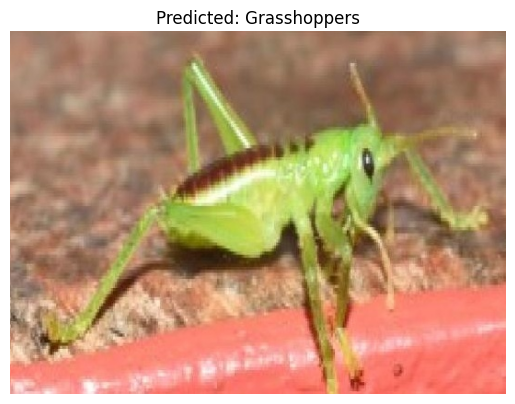

In [40]:
# confirm?
from PIL import Image
img_path = "cls_dataset/test/Grasshoppers/grasshopper-11-_jpg.rf.0746dc023efddc064bcdd4c2784fbf16.jpg"
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)
# Apply SAME transforms used during testing/validation
img_tensor = test_tf(img_pil).unsqueeze(0).to(device)
with torch.no_grad():
    outputs = resnet_model(img_tensor)
    pred_idx = outputs.argmax(1).item()

pred_class = classes[pred_idx]

print(f"Predicted Class: {pred_class}")

# -------------------------
# Visualize the image
# -------------------------
plt.imshow(img_rgb)
plt.title(f"Predicted: {pred_class}")
plt.axis("off")
plt.show()